# Predict electrical energy output

Dataset: https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

Citation(s):<p>
Elkhawad Elfaki, Ahmed Hassan Ahmed Hassan. Prediction of Electrical Output Power of Combined Cycle Power Plant Using Regression
ANN Model. International Journal of Computer Science and Control Engineering. Vol. 6, No. 2, 2018, pp. 9-21, DOI:
10.5281/zenodo.1285164. https://zenodo.org/record/1285164/files/CCPP%20using%20ANN%20.pdf

Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.

Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)

In [214]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as ssm #for detail description of linear coefficients, intercepts, deviations, and many more
from sklearn import linear_model
from sklearn import metrics

plt.style.use('seaborn-colorblind')

# print out all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load dataset and inspect

In [3]:
# load dataset

data_file = Path("Folds5x2_pp.xlsx")
if data_file.is_file():
    merged_data = pd.read_excel(data_file,sheet_name=[0,1,2,3,4],
                                names=['Temperature','Exhaust Vacuum','Ambient Pressure','Relative Humidity','Power'])
#     # read values for each bearing and load into OCS
#     for i in range(1,5):
#         values = (merged_data[f'bearing {i}']
#                     .reset_index()
#                     .rename(columns={'index':'timestamp',f'bearing {i}':'channel'})
#                     .to_json(orient='records'))
#         ocsClient.Streams.updateValues(namespace_id,f'{example_prefix}bearing{i}.agg',values)
else:
    print(f'Unable to read file: {data_file}')

In [4]:
# count values and check for null values
for frame in merged_data.items():
    frame[1].count()
    frame[1].isnull().values.sum()

Temperature          9568
Exhaust Vacuum       9568
Ambient Pressure     9568
Relative Humidity    9568
Power                9568
dtype: int64

0

Temperature          9568
Exhaust Vacuum       9568
Ambient Pressure     9568
Relative Humidity    9568
Power                9568
dtype: int64

0

Temperature          9568
Exhaust Vacuum       9568
Ambient Pressure     9568
Relative Humidity    9568
Power                9568
dtype: int64

0

Temperature          9568
Exhaust Vacuum       9568
Ambient Pressure     9568
Relative Humidity    9568
Power                9568
dtype: int64

0

Temperature          9568
Exhaust Vacuum       9568
Ambient Pressure     9568
Relative Humidity    9568
Power                9568
dtype: int64

0

In [5]:
# merge dataset
plant = merged_data[0]
for i in range(1,len(merged_data)): 
    plant = pd.concat([plant,merged_data[i]],ignore_index=True)
plant = plant.reindex()

In [6]:
plant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47840 entries, 0 to 47839
Data columns (total 5 columns):
Temperature          47840 non-null float64
Exhaust Vacuum       47840 non-null float64
Ambient Pressure     47840 non-null float64
Relative Humidity    47840 non-null float64
Power                47840 non-null float64
dtypes: float64(5)
memory usage: 1.8 MB


In [7]:
plant.count()/merged_data[0].count()

Temperature          5.0
Exhaust Vacuum       5.0
Ambient Pressure     5.0
Relative Humidity    5.0
Power                5.0
dtype: float64

# visualize dataset

In [8]:
plant.head()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Power
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


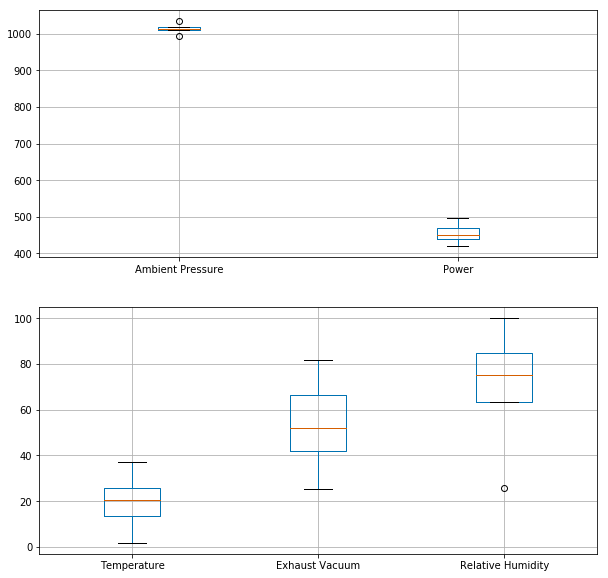

In [9]:
# boxplot columns

df = plant.describe()

# split into two plots
column_sets = [['Temperature','Exhaust Vacuum','Relative Humidity'],['Ambient Pressure','Power']]
# subset of rows to plot
xlabels = ['min','25%','50%','75%','max']

fig, axs = plt.subplots(2,1,figsize=(10,10))

# plot column_sets
for plot in range(0,2):
    df_temp = df.drop(columns=column_sets[plot],index=['count'])
    df_temp = df_temp.reindex(xlabels)
    df_temp.boxplot(ax=axs[plot])
    df_temp
    axs[plot].set_xticklabels(df_temp.columns)
plt.show();

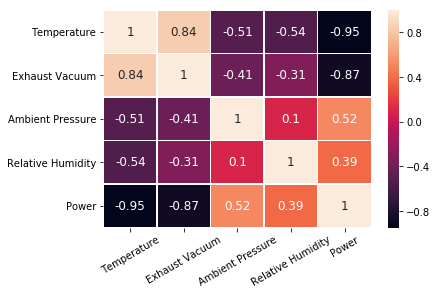

In [10]:
# Customize correlation matrix
sns.heatmap(plant.corr(),
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 12})

plt.xticks(rotation=30);
plt.yticks(rotation=0) ;
plt.show();

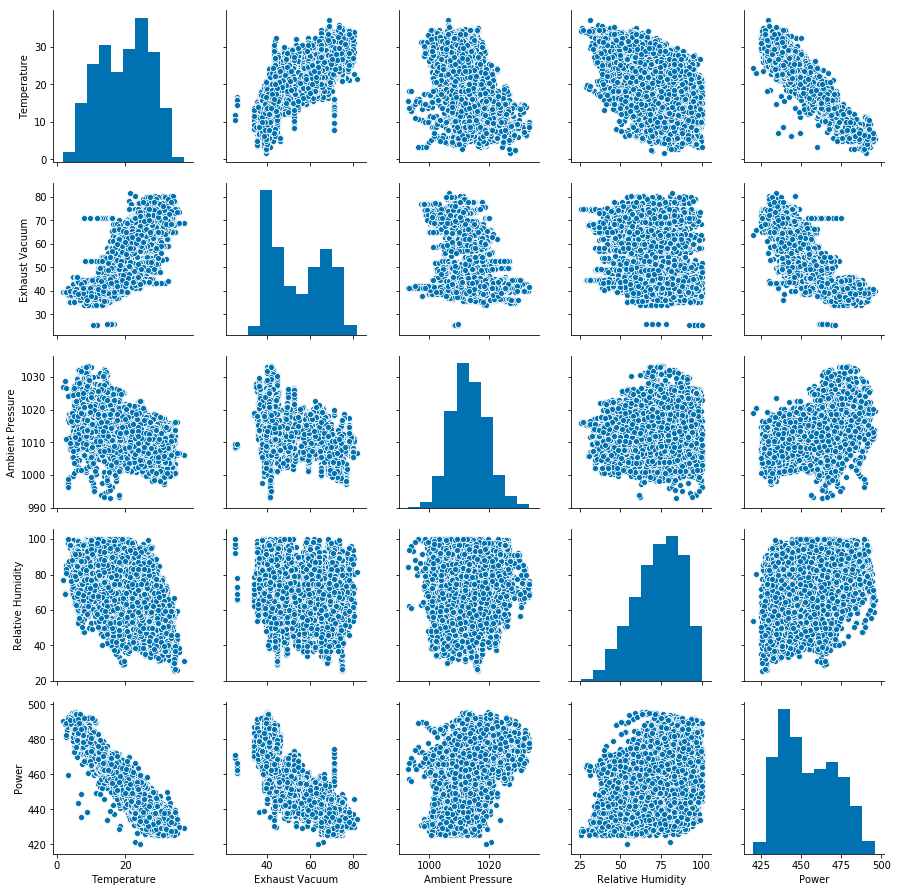

In [95]:
# visualize relationship between measures
sns.pairplot(plant);

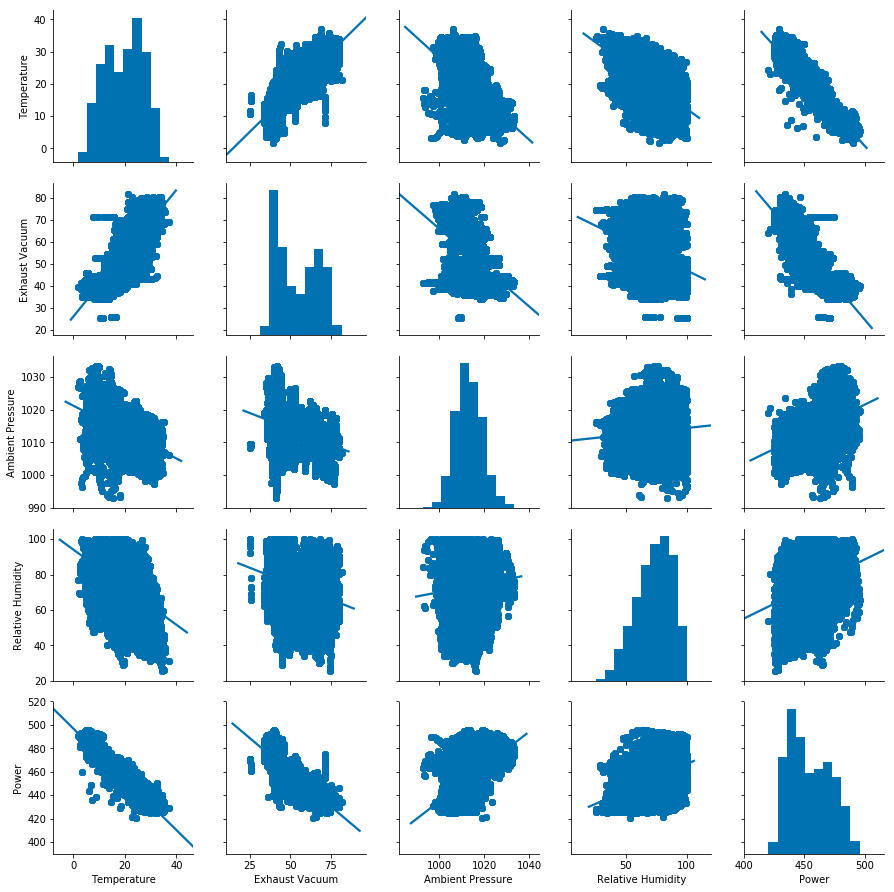

In [96]:
# visualize relationship between measures
sns.pairplot(plant,kind="reg");

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


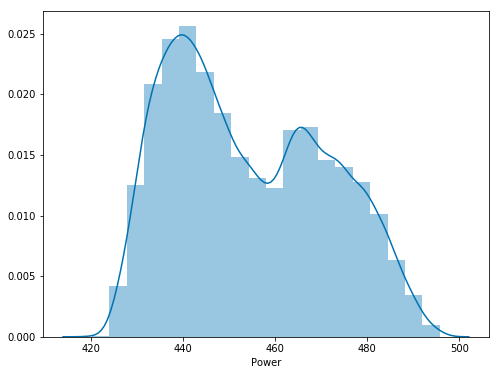

In [12]:
# histogram of target values indicate data is not representitive of a normal distribution, i.e.: non-parametric which may influence model selection
fig = plt.figure(figsize=(8,6))
sns.distplot(plant['Power'],bins=20);

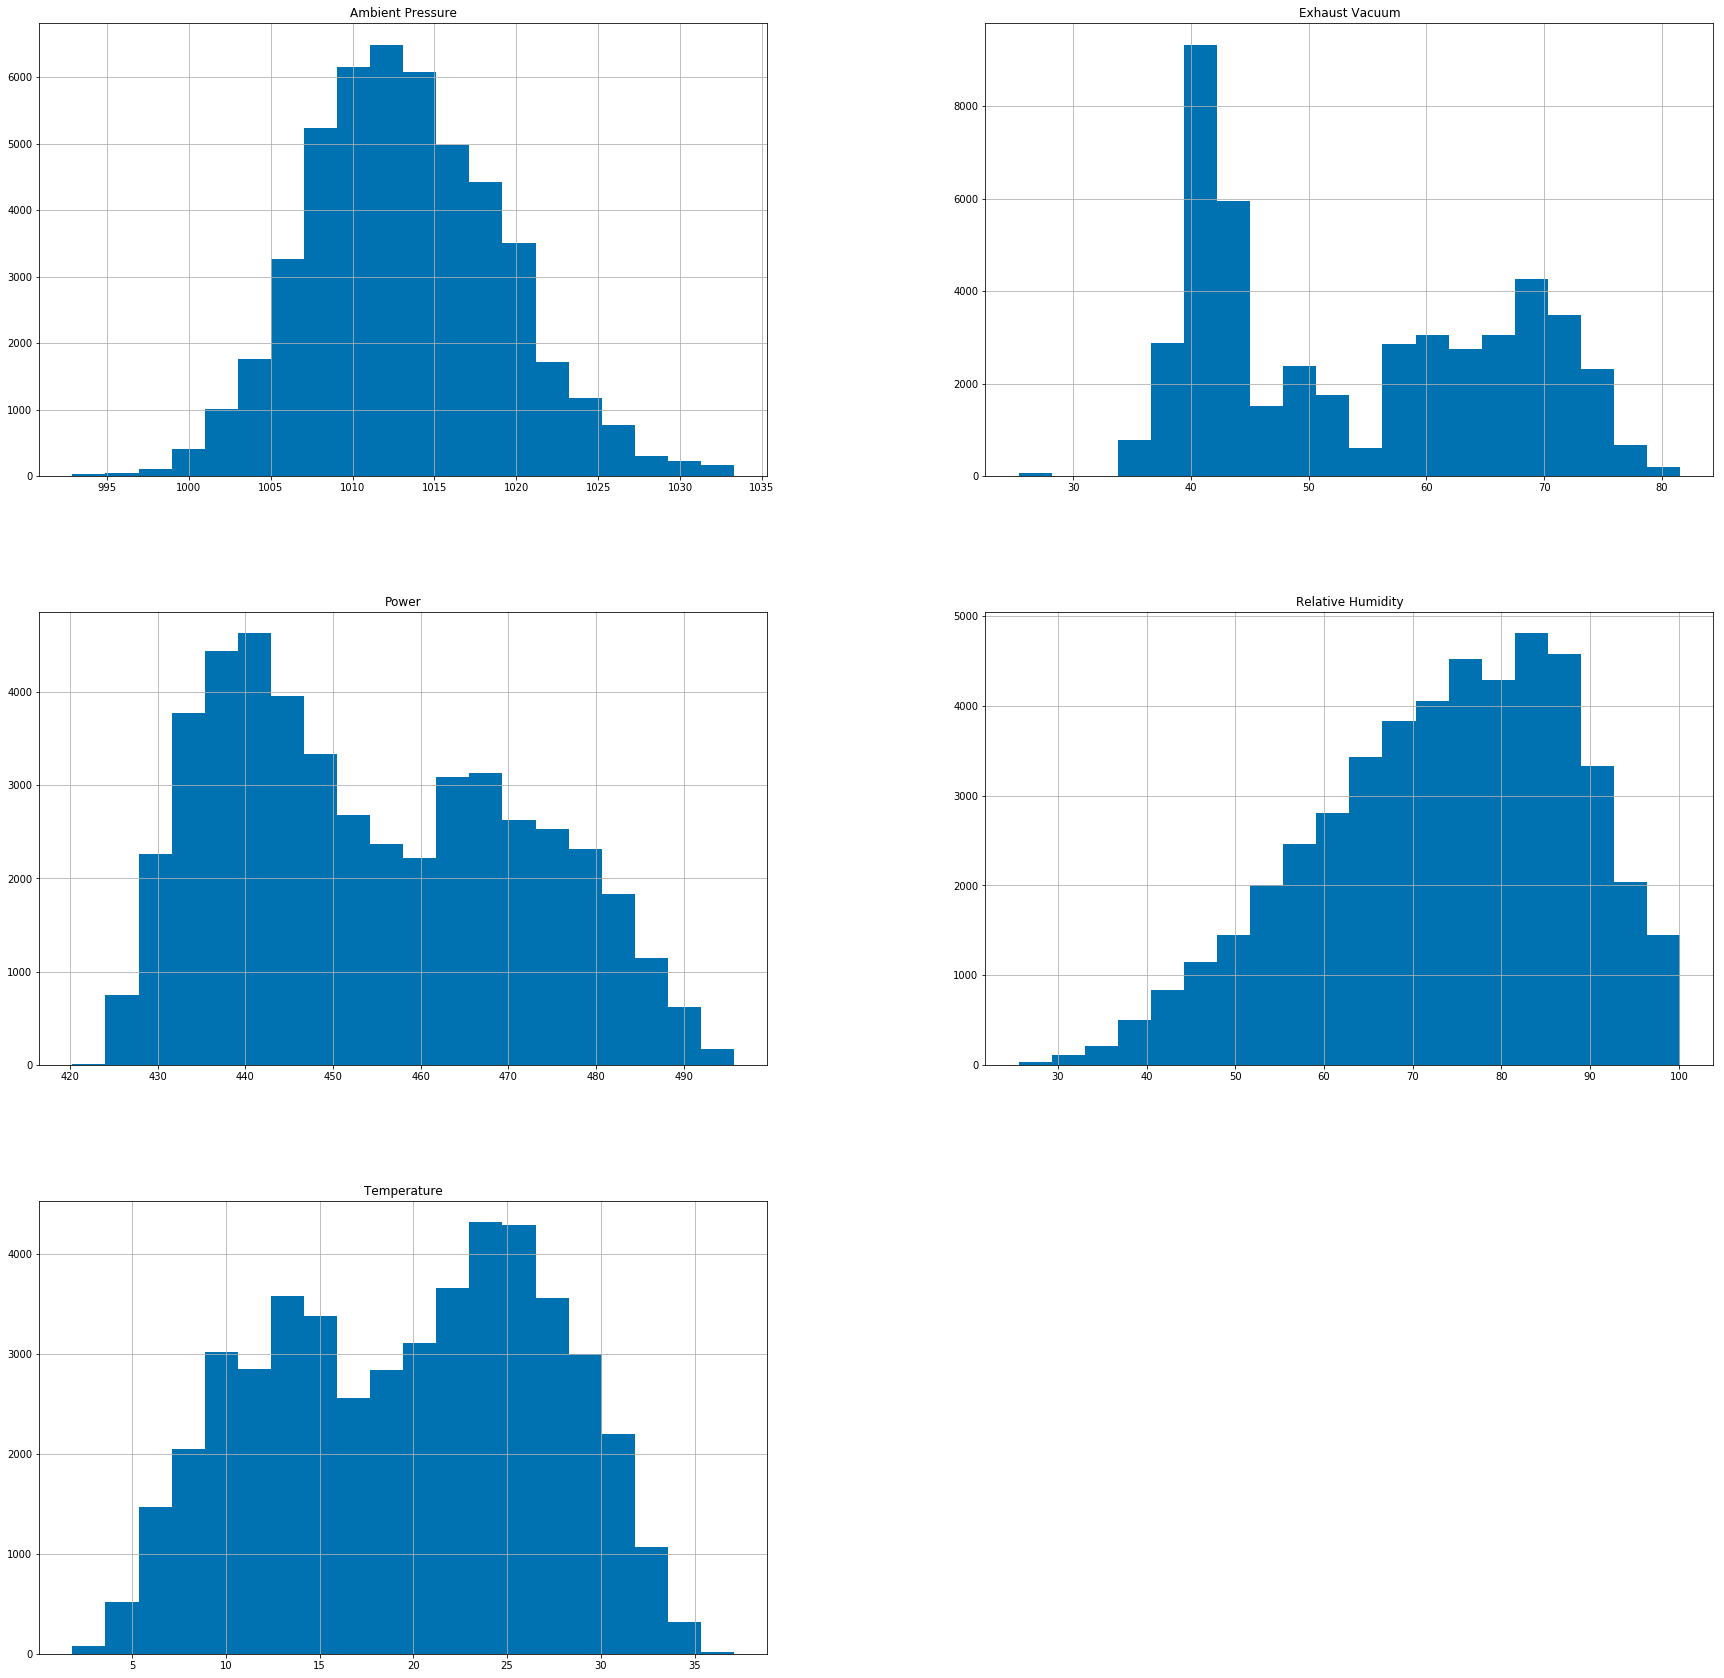

In [76]:
plant.hist(bins=20,figsize=(30,30));

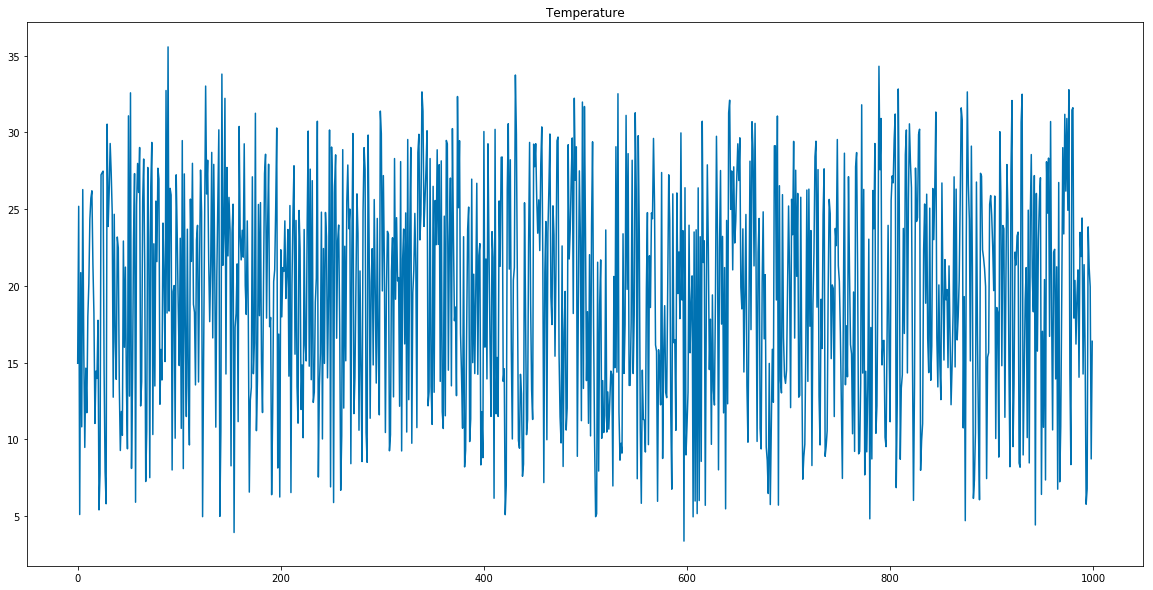

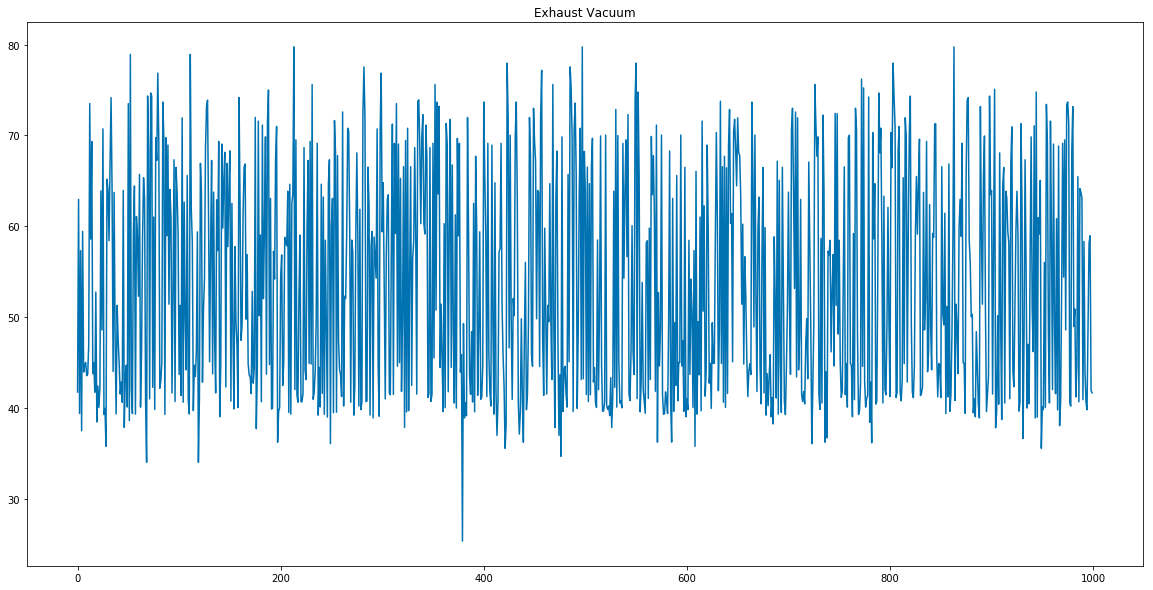

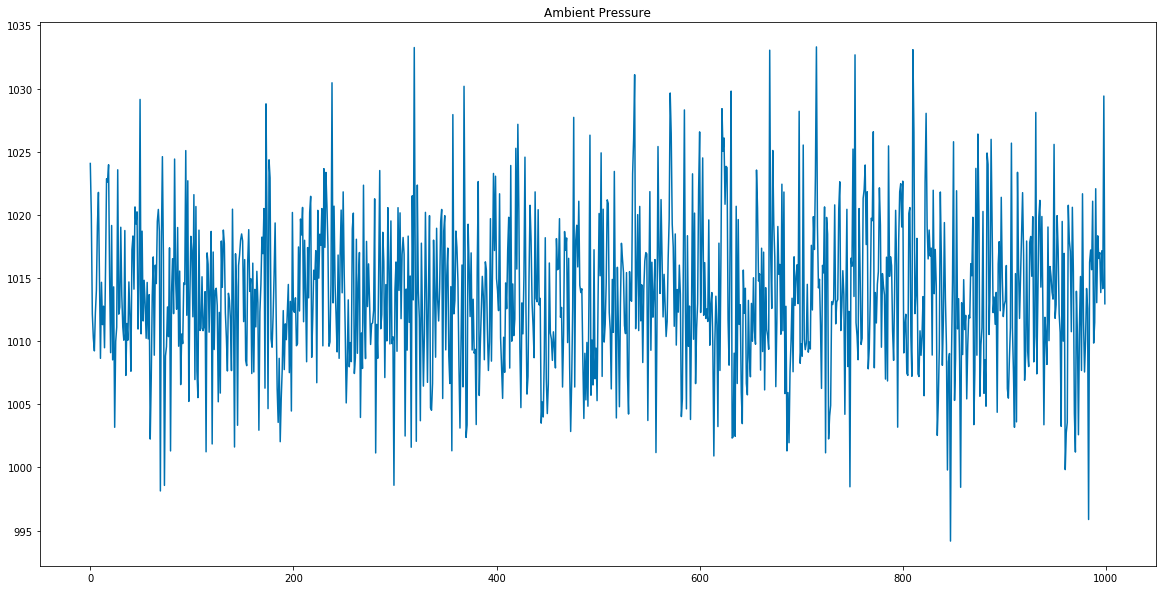

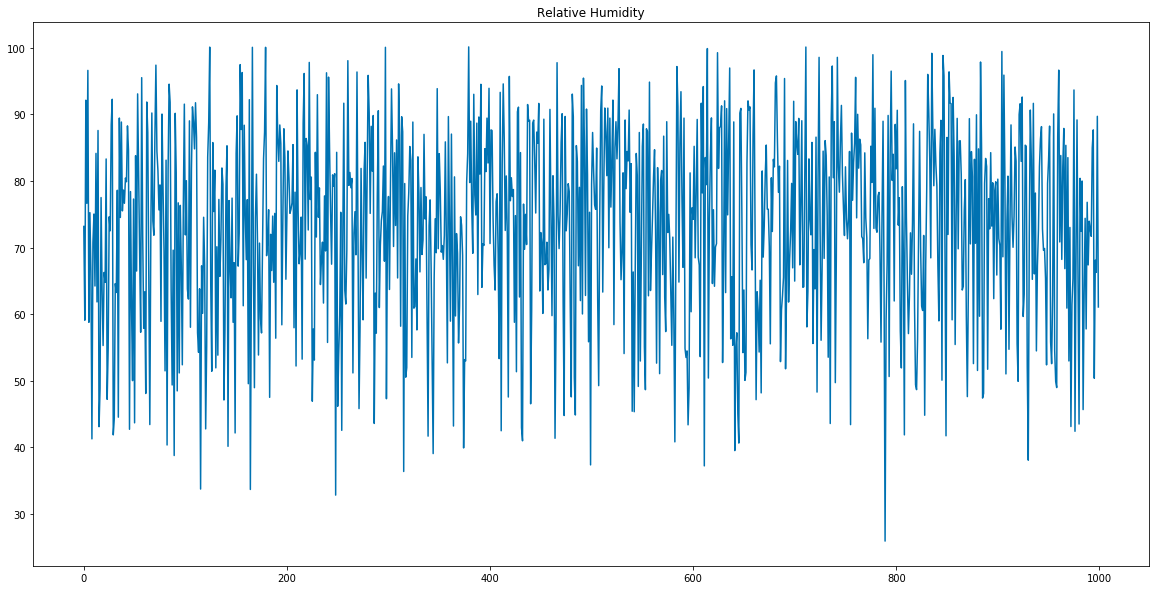

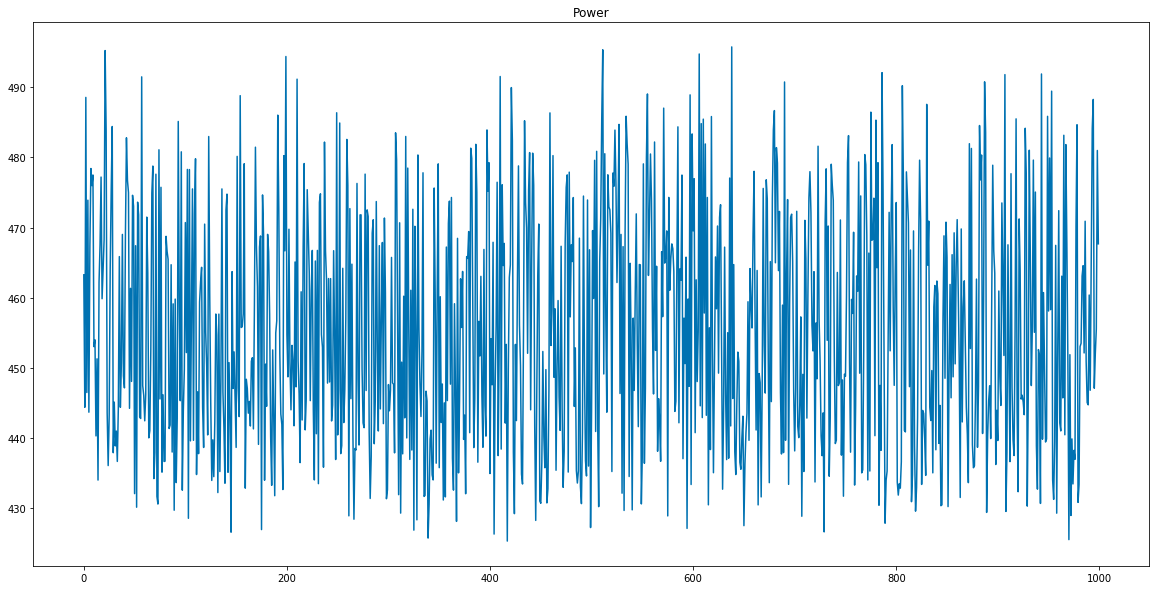

In [72]:
# plot first 1000 values for each variable
for column in plant:
    ax = plant[column][:1000].plot(figsize=(20,10))
    _ = ax.set_title(column)
    plt.show();
    plt.close();

# Create a model to infer power values

In [121]:
# how many records?
plant.shape[0]
(plant.shape[0])*.75
plant.shape[0]*.25
# column names?
print(plant.columns.values)

47840

35880.0

11960.0

['Temperature' 'Exhaust Vacuum' 'Ambient Pressure' 'Relative Humidity'
 'Power']


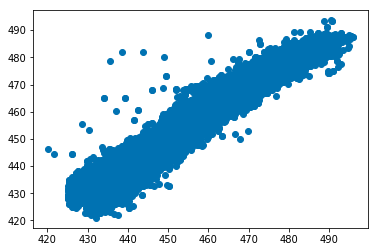

In [220]:
# split data and build model

train_size = 35880
X_train = plant.loc[:train_size, plant.columns != 'Power']
y_train = plant.loc[:train_size,'Power']

X_test = plant.loc[train_size+1:,plant.columns != 'Power']
y_test = plant[train_size+1:]['Power']

model = linear_model.LinearRegression()
model.fit(X_train,y_train);
y_pred = model.predict(X_test)
#model.coef_
plt.scatter(y_test,y_pred);

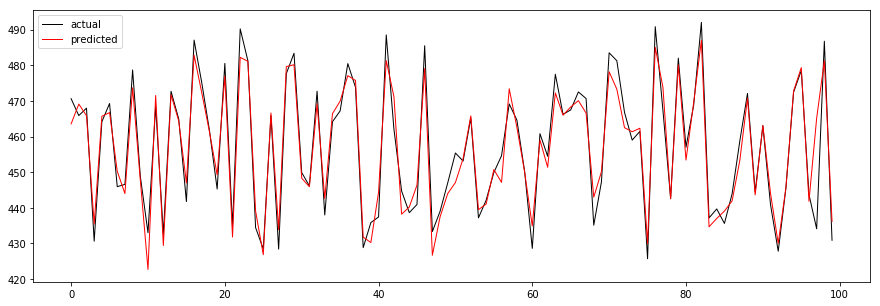

In [258]:
# Visualize our predictions along with the "true" values, and print the score
display_index = 100
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.reset_index(drop=True).iloc[:display_index], color='k', lw=1,label='actual')
ax.plot(y_pred[:display_index], color='r', lw=1,label='predicted')
ax.legend()
plt.show();

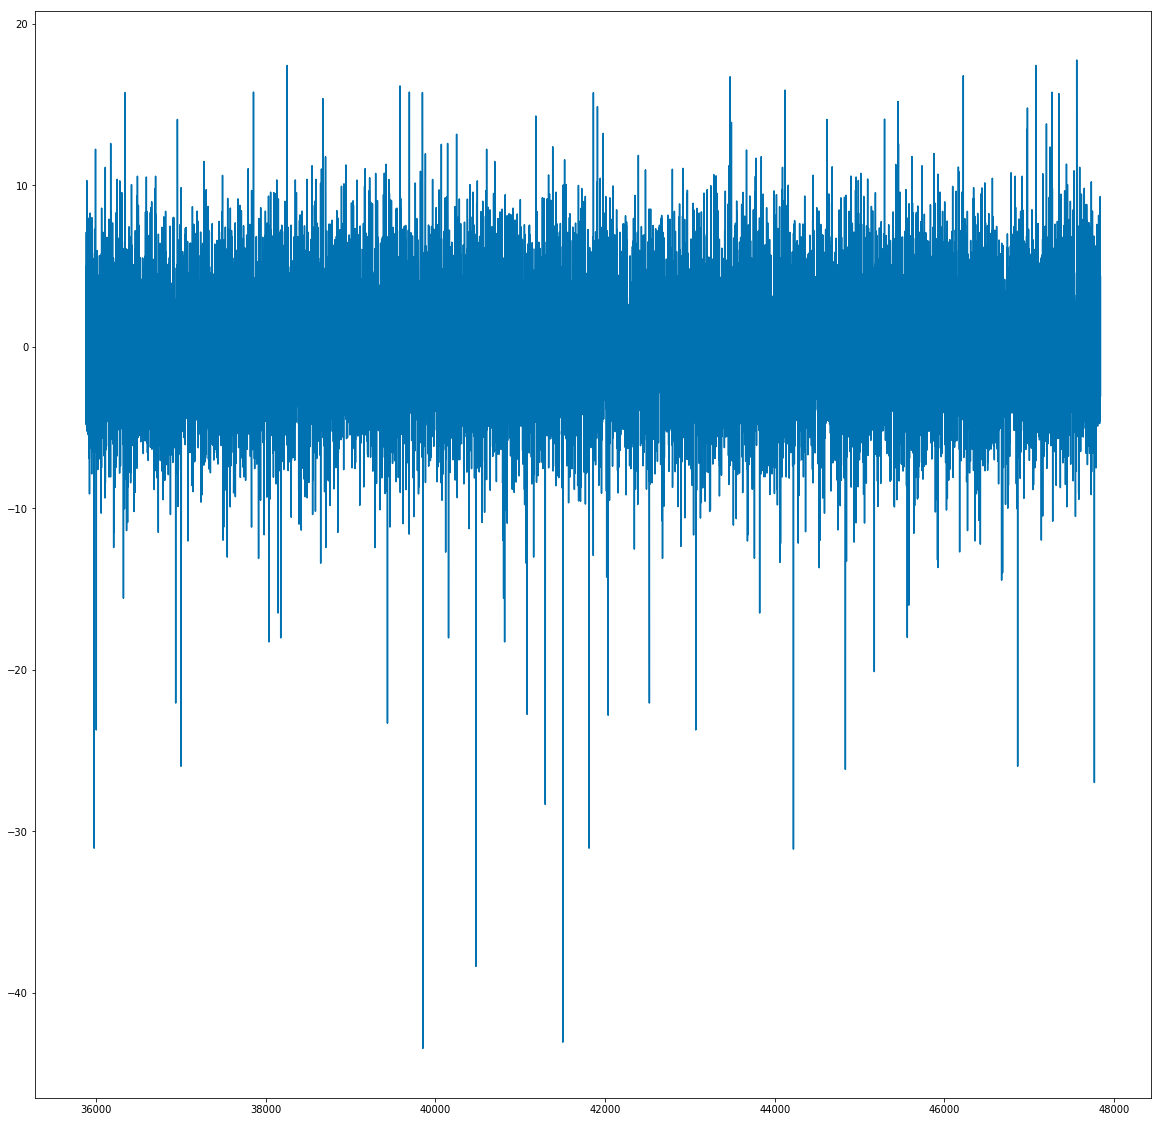

In [183]:
fig = plt.figure(figsize=(20,20))
plt.hlines(1,xmin=y_test.index[0],xmax=y_test.index[-1]);
plt.plot(y_test - y_pred);

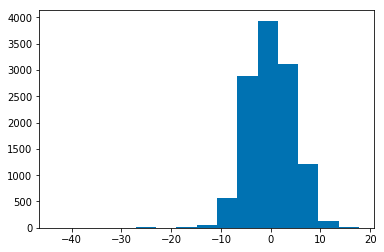

In [153]:
plt.hist(y_test - plant_predictions,bins=15);

In [263]:
print(f"""
R2:   {metrics.r2_score(y_test,y_pred)}
MAE:  {metrics.mean_absolute_error(y_test, y_pred)}
MSE:  {metrics.mean_squared_error(y_test, y_pred)}
RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}""")


R2:   0.9288091885159396
MAE:  3.621006789013612
MSE:  20.637468037031812
RMSE: 4.542848009457483


In [262]:
# coefficient values
# from https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb
params = pd.Series(model.coef_, index=X_test.columns)
params

Temperature         -1.976362
Exhaust Vacuum      -0.234108
Ambient Pressure     0.064376
Relative Humidity   -0.157672
dtype: float64

# create model using statsmodel and compare

In [218]:
# compare with statsmodel
#X=ssm.add_constant(X_train)        #to add constant value in the model
model = ssm.OLS(y_train,X_train).fit()   #fitting the model
predictions = model.summary()       #summary of the model
predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Power   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.167e+05
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        01:12:17   Log-Likelihood:            -1.0537e+05
No. Observations:               35881   AIC:                         2.108e+05
Df Residuals:                   35876   BIC:                         2.108e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               452.2484      5.032     89.876      0.000     442.386     462.111
Temperature          -1.9764      0.008   -250.485      0.000      -1.992      -1.961
Exhaust Vacuum       -0.2341      0.004    -62.242      0.000      -0.241      -0.227
Ambient Pressure      0.0644      0.005     13.186      0.000       0.055       0.074
Relative Humidity    -0.1577      0.002    -73.257      0.000      -0.162      -0.153
==============================================================================
Omnibus:                     3407.755   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16186.066
Skew:                          -0.354   Prob(JB):                         0.00
Kurtosis:                       6.213   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# test across a variety of train/test datasets

In [318]:
# Create KFold cross-validation object and run models on train/test pairs
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False, random_state=1)

X = plant.loc[:,plant.columns != 'Power']
y = plant.loc[:,['Power']]

# Iterate through CV splits
results = []
for train, test in cv.split(X, y):

    # Fit the model on training data
    _ = model.fit(X.iloc[train],y.iloc[train])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X.iloc[test])
    results.append((metrics,y.iloc[test],prediction))

In [320]:
# print r^2 for each train/test pair
for result in results:
    print(f'R2: {result[0].r2_score(result[1],result[2]):.3}')

R2: 0.929
R2: 0.928
R2: 0.928
R2: 0.929
R2: 0.929
R2: 0.928
R2: 0.926
R2: 0.932
R2: 0.927
R2: 0.931
